In [1]:
from src.models.propensity_scores.nlp.text_ts import text_timeseries

df = text_timeseries()

  0%|          | 0/13 [00:00<?, ?it/s]

In [2]:
from sklearn.model_selection import train_test_split

from src.paths import processed_data

path = processed_data / "propensity_scores/nlp/transformer"
path.mkdir(exist_ok=True, parents=True)

train, test = train_test_split(df, test_size=0.2, shuffle=False)
train.to_json(path / f"train.jsonl", orient="records", lines=True)
test.to_json(path / f"test.jsonl", orient="records", lines=True)

Sources:

- Llama 2 https://ai.meta.com/research/publications/llama-2-open-foundation-and-fine-tuned-chat-models/
    - https://huggingface.co/meta-llama/Llama-2-7b-chat-hf
- QLoRA https://arxiv.org/abs/2305.14314
    - https://huggingface.co/docs/transformers/v4.32.0/perf_train_gpu_one
    - https://huggingface.co/blog/4bit-transformers-bitsandbytes
    - https://colab.research.google.com/drive/1VoYNfYDKcKRQRor98Zbf2-9VQTtGJ24k?usp=sharing#scrollTo=jq0nX33BmfaC
    - https://blog.ovhcloud.com/fine-tuning-llama-2-models-using-a-single-gpu-qlora-and-ai-notebooks/
    - https://huggingface.co/docs/transformers/main/main_classes/trainer

In [3]:
# %pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7 scikit-learn scipy xformers evaluate

In [4]:
import os

import torch
from datasets import load_dataset
from peft import LoraConfig, PeftModel, get_peft_model
from transformers import (
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    Trainer,
    TrainingArguments,
    logging,
    pipeline,
)
from trl import SFTTrainer

In [5]:
split = 0
# model_name = "jphme/Llama-2-13b-chat-german"
# model_name = "deepset/gelectra-base"
model_name = "LennartKeller/longformer-gottbert-base-8192-aw512"
# new_model = f"llama-2-13b-custom-split-{split}"
# new_model = f"gelectra-custom-split-{split}"
new_model = f"gottbert-custom-split-{split}"
max_seq_length = 1024

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

In [7]:
path = "../data/processed/propensity_scores/nlp/transformer/"
train_dataset = load_dataset(
    "json", data_files=path + f"train_{split}.jsonl", split="train"
).shuffle(seed=100)
valid_dataset = load_dataset(
    "json", data_files=path + f"test_{split}.jsonl", split="train"
).shuffle(seed=100)


def mapper(examples):
    return {
        "text": examples["text"],
        "label": [int(y == "yes") for y in examples["label"]],
    }


train_dataset = train_dataset.map(mapper, batched=True)
valid_dataset = valid_dataset.map(mapper, batched=True)


def tokenize_(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=max_seq_length,
    )


train_tokenized = train_dataset.map(tokenize_, batched=True, remove_columns=["text"])
valid_tokenized = valid_dataset.map(tokenize_, batched=True, remove_columns=["text"])

In [9]:
model = AutoModelForSequenceClassification.from_pretrained(model_name)

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at LennartKeller/longformer-gottbert-base-8192-aw512 and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
import evaluate
import numpy as np

metric = evaluate.load("f1")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


from torch import nn, tensor
from transformers import Trainer


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # adapted from https://huggingface.co/docs/transformers/main/main_classes/trainer
        labels = inputs.pop("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (class 0 has 95% of the samples and class 1 has 5% of the samples)
        weights = tensor([1 / 0.95, 1 / 0.05], device=labels.device)
        loss_fct = nn.CrossEntropyLoss(weight=weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [29]:
training_arguments = TrainingArguments(
    output_dir=f"./results_split_{split}",
    log_level="info",
    evaluation_strategy="epoch",
    logging_strategy="steps",
    logging_steps=10,
    logging_dir="./logs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    report_to="none",
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    learning_rate=5e-6,
    weight_decay=0.2,
    num_train_epochs=5,
)
model.config.use_cache = False
trainer = CustomTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_tokenized,
    eval_dataset=valid_tokenized,
    compute_metrics=compute_metrics,
)

Found safetensors installation, but --save_safetensors=False. Safetensors should be a preferred weights saving format due to security and performance reasons. If your model cannot be saved by safetensors please feel free to open an issue at https://github.com/huggingface/safetensors!
PyTorch: setting up devices


In [17]:
train_result = trainer.train()
metrics = train_result.metrics
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()
print(metrics)

# Saving model
output_dir = f"final_split_{split}"
print("Saving last checkpoint of the model...")
os.makedirs(output_dir, exist_ok=True)
trainer.model.save_pretrained(output_dir)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 9,230
  Num Epochs = 30
  Instantaneous batch size per device = 8
  Training with DataParallel so batch size has been adjusted to: 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 4,350
  Number of trainable parameters = 153,146,882


Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...


Epoch,Training Loss,Validation Loss,F1
1,0.682400,0.690150,0.111947
2,0.677700,0.650447,0.153658
3,0.679100,0.612286,0.192864
4,0.604600,0.612868,0.231827
5,0.586100,0.589749,0.211055
6,0.553000,0.608636,0.222593
7,0.542000,0.619028,0.233696
8,0.574400,0.625672,0.220183
9,0.481600,0.736465,0.256121
10,0.423800,0.748826,0.243004


Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on C

***** train metrics *****
  epoch                    =        30.0
  total_flos               = 169391009GF
  train_loss               =      0.3636
  train_runtime            =  1:48:51.89
  train_samples_per_second =      42.392
  train_steps_per_second   =       0.666
{'train_runtime': 6531.8937, 'train_samples_per_second': 42.392, 'train_steps_per_second': 0.666, 'total_flos': 1.818822112653312e+17, 'train_loss': 0.3635943338925811, 'epoch': 30.0}
Saving last checkpoint of the model...


Model weights saved in final_split_0/pytorch_model.bin


In [18]:
train_result.metrics

{'train_runtime': 6531.8937,
 'train_samples_per_second': 42.392,
 'train_steps_per_second': 0.666,
 'total_flos': 1.818822112653312e+17,
 'train_loss': 0.3635943338925811,
 'epoch': 30.0}

In [ ]:
import json

with open("./models/propensity_scores/trainer_state.json") as f:
    training_loss = json.load(f)["log_history"]

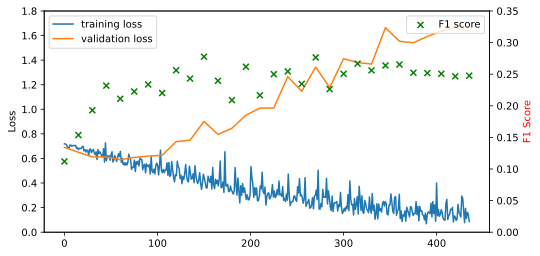

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib_inline.backend_inline import set_matplotlib_formats
from scipy import interpolate

set_matplotlib_formats("svg")

# training_loss = trainer.state.log_history
validation_loss = [log for log in training_loss if "eval_loss" in log]

training_loss_values = [log["loss"] for log in training_loss if "loss" in log]
validation_loss_values = [
    log["eval_loss"] for log in validation_loss if "eval_loss" in log
]

training_steps = np.linspace(0, len(training_loss_values), len(training_loss_values))
validation_steps = np.linspace(
    0, len(training_loss_values), len(validation_loss_values)
)

f = interpolate.interp1d(validation_steps, validation_loss_values)
validation_loss_values_interp = f(training_steps)

f1_scores = [log["eval_f1"] for log in validation_loss if "eval_f1" in log]
f1_steps = np.linspace(0, len(training_loss_values), len(f1_scores))

fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.plot(training_steps, training_loss_values, label="training loss")
ax1.plot(validation_steps, validation_loss_values, label="validation loss")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper left")
ax1.set_ylim(0, 1.8)
ax2 = ax1.twinx()
ax2.scatter(f1_steps, f1_scores, label="F1 score", color="g", marker="x")
ax2.set_ylabel("F1 Score", color="r")
ax2.legend(loc="upper right")
ax2.set_ylim(0, 0.35)

plt.show()